In [48]:
# commit: add CIFAR-10 dataset with transforms and dataloaders

import torch
import torchvision
import torchvision.transforms as transforms

# train transforms (flip, crop, normalize)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# test transforms (tensor + normalize)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# train dataset + loader
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)

# test dataset + loader
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=2
)

# class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Train batches:", len(trainloader))
print("Test batches:", len(testloader))


Train batches: 782
Test batches: 157


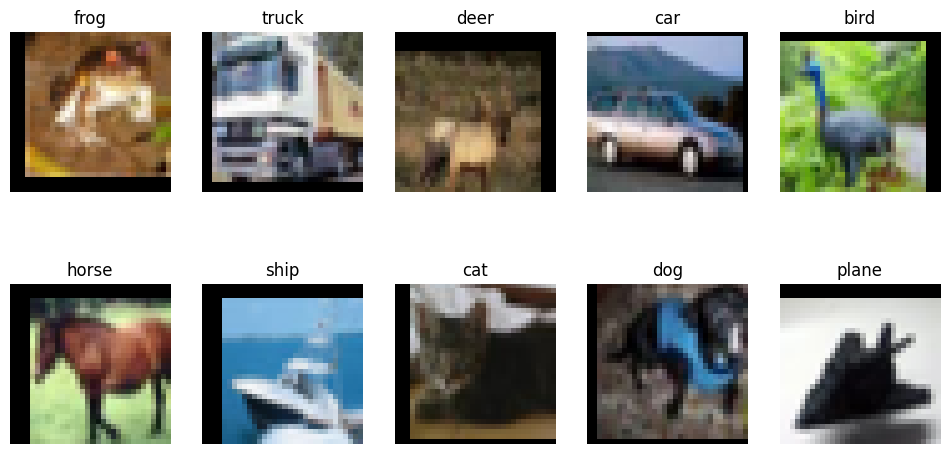

In [49]:
# commit: add CIFAR-10 sample visualization with matplotlib

import matplotlib.pyplot as plt
import numpy as np

# unnormalize image for display
def imshow(img):
    img = img / 2 + 0.5     # (-1,1) -> (0,1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")

# pick one example per class
examples = {}
for img, label in trainset:
    cls_name = classes[label]
    if cls_name not in examples:
        examples[cls_name] = img
    if len(examples) == len(classes):
        break

# plot all 10 classes
plt.figure(figsize=(12, 6))
for idx, (cls, img) in enumerate(examples.items()):
    plt.subplot(2, 5, idx+1)
    imshow(img)
    plt.title(cls)
plt.show()


In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [50]:
# commit: implement LeNet-5 model for CIFAR-10 classification

import torch
import torch.nn as nn

class Lenet5(nn.Module):
    def __init__(self):
        super(Lenet5,self).__init__()
        self.Features = nn.Sequential(
            nn.Conv2d(3,6,kernel_size=5,stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Conv2d(6,16,kernel_size=5,stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2,stride=2)
        )

        # conv output shape calc:
        # input 32x32 -> conv1 28x28 -> pool 14x14
        # conv2 10x10 -> pool 5x5
        # channels: 16 -> flatten 16*5*5 = 400

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5,120),
            nn.Tanh(),
            nn.Linear(120,84),
            nn.Tanh(),
            nn.Linear(84, 10)  # 10 classes
        )

    def forward(self,x):
        x = self.Features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x


In [51]:
model = Lenet5()

In [52]:
model = model.to(device)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay=1e-5,momentum=0.9)

In [54]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [55]:
epochs =30

Epoch [1/30] | Train Loss: 2.1781, Train Acc: 0.1891 | Val Loss: 2.0251, Val Acc: 0.2482
Epoch [2/30] | Train Loss: 2.0121, Train Acc: 0.2592 | Val Loss: 1.9495, Val Acc: 0.2998
Epoch [3/30] | Train Loss: 1.9618, Train Acc: 0.2875 | Val Loss: 1.8928, Val Acc: 0.3348
Epoch [4/30] | Train Loss: 1.9108, Train Acc: 0.3123 | Val Loss: 1.8355, Val Acc: 0.3508
Epoch [5/30] | Train Loss: 1.8714, Train Acc: 0.3274 | Val Loss: 1.7914, Val Acc: 0.3662
Epoch [6/30] | Train Loss: 1.8421, Train Acc: 0.3394 | Val Loss: 1.7618, Val Acc: 0.3777
Epoch [7/30] | Train Loss: 1.8152, Train Acc: 0.3492 | Val Loss: 1.7316, Val Acc: 0.3867
Epoch [8/30] | Train Loss: 1.7926, Train Acc: 0.3549 | Val Loss: 1.7018, Val Acc: 0.3990
Epoch [9/30] | Train Loss: 1.7610, Train Acc: 0.3679 | Val Loss: 1.6604, Val Acc: 0.4083
Epoch [10/30] | Train Loss: 1.7173, Train Acc: 0.3808 | Val Loss: 1.6122, Val Acc: 0.4198
Epoch [11/30] | Train Loss: 1.6699, Train Acc: 0.3983 | Val Loss: 1.5636, Val Acc: 0.4326
Epoch [12/30] | Tra

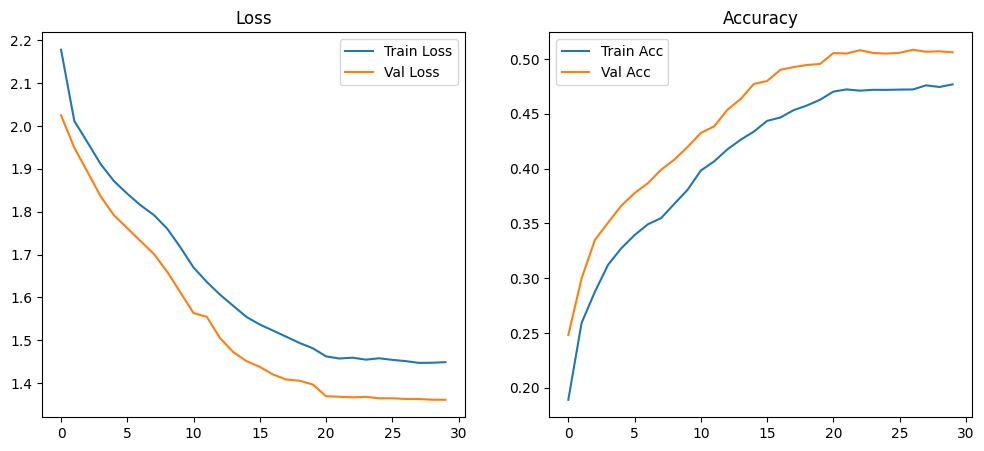

In [56]:
# commit: add training & validation loop with model saving and plots

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os


# trackers
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

# save dir for model & plots
save_dir = "/content/drive/MyDrive/CIFAR_Models"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(epochs):
    # --- train ---
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / len(trainloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- validation ---
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(testloader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model_lenet5.pth"))
    scheduler.step()

# plot loss & acc
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.savefig(os.path.join(save_dir, "loss_accuracy_plot.png"))
plt.show()
